# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [158]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import getFamaFrenchFactors as gff
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('default')

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [159]:
def prendi_dati_titolo(ticker, start_date, end_date):
    
    data_dir = "DatiFinanziari" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def carica_da_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            if(df.index[0] > start_date):
                return None
            else:
                df = df.loc[start_date:end_date]
                return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def scarica_da_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = carica_da_csv()
    
    if data is None or data.empty:
        data = scarica_da_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [160]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

settore_1 = 'Tecnologia elettronica'
settore_2 = 'Vendita al dettaglio'
settore_3 = 'Servizi commerciali'

tickers_settore1 = ['AAPL', 'INTC'] # Tecnologia elettronica
tickers_settore2 = ['AMZN', 'WMT'] # Vendita al dettaglio
tickers_settore3 = ['V', 'MA'] # Servizi commerciali

# Apple, Intel, Amazon, Walmart, Visa, Mastercard
tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

for ticker in tickers:
    df = prendi_dati_titolo(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.859396   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.140238   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.370213   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.450140   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.393913   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In [161]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.859396,20.856438,15.442000,20.799509,49.775631,72.443565
2014-06-03,20.140238,21.162470,15.359500,20.785965,49.262787,71.785416
2014-06-04,20.370213,21.116568,15.339000,20.899765,49.288425,71.757202
2014-06-05,20.450140,21.162470,16.178499,20.951246,49.472595,72.246109
2014-06-06,20.393913,21.552670,16.483500,20.921448,49.654415,72.838463
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


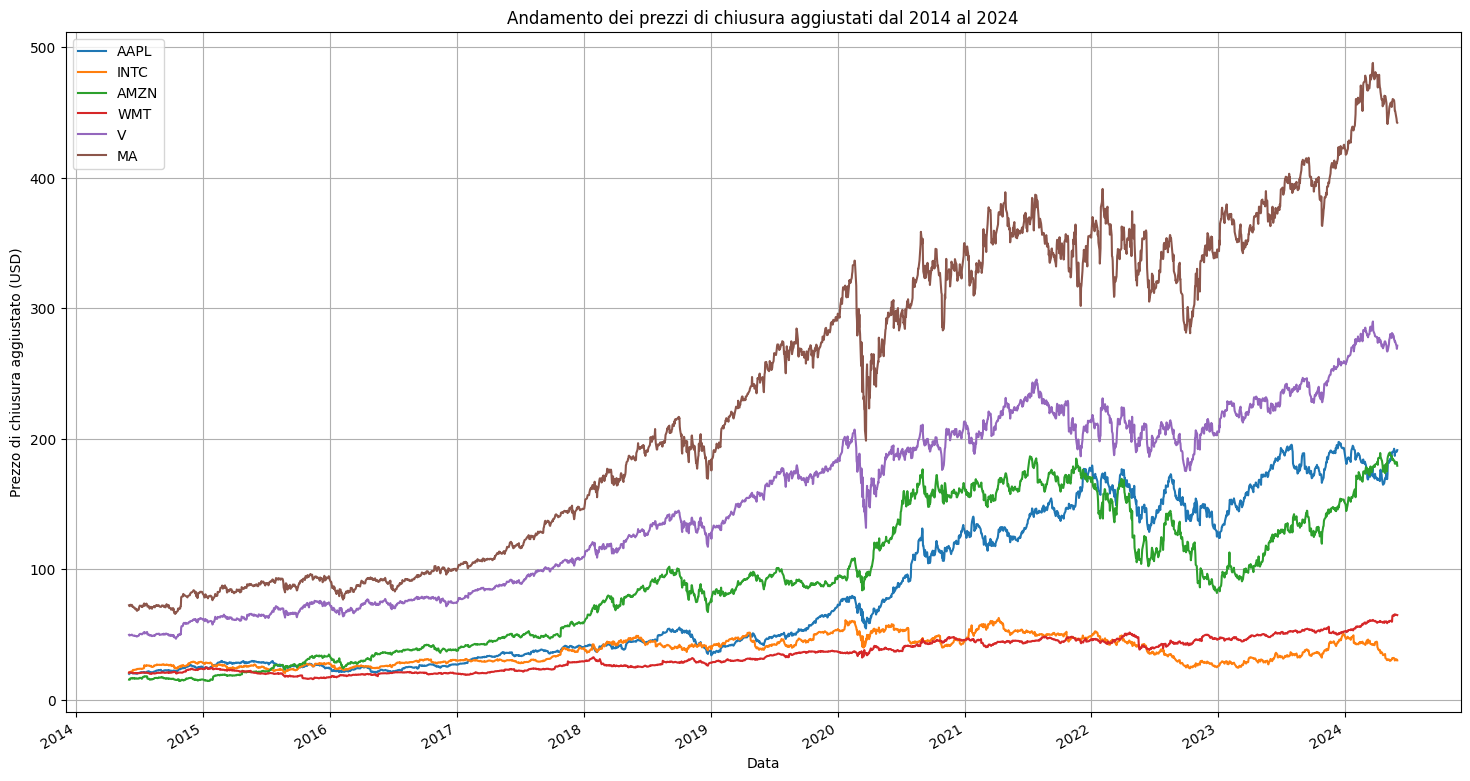

In [162]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [163]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
mappa_colori = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=mappa_colori(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [164]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014142,0.014673,-0.005343,-0.000651,-0.010303,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000520,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003737,0.006813
2014-06-06,-0.002749,0.018438,0.018852,-0.001422,0.003675,0.008199
2014-06-09,0.016001,-0.009230,-0.006582,-0.002590,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


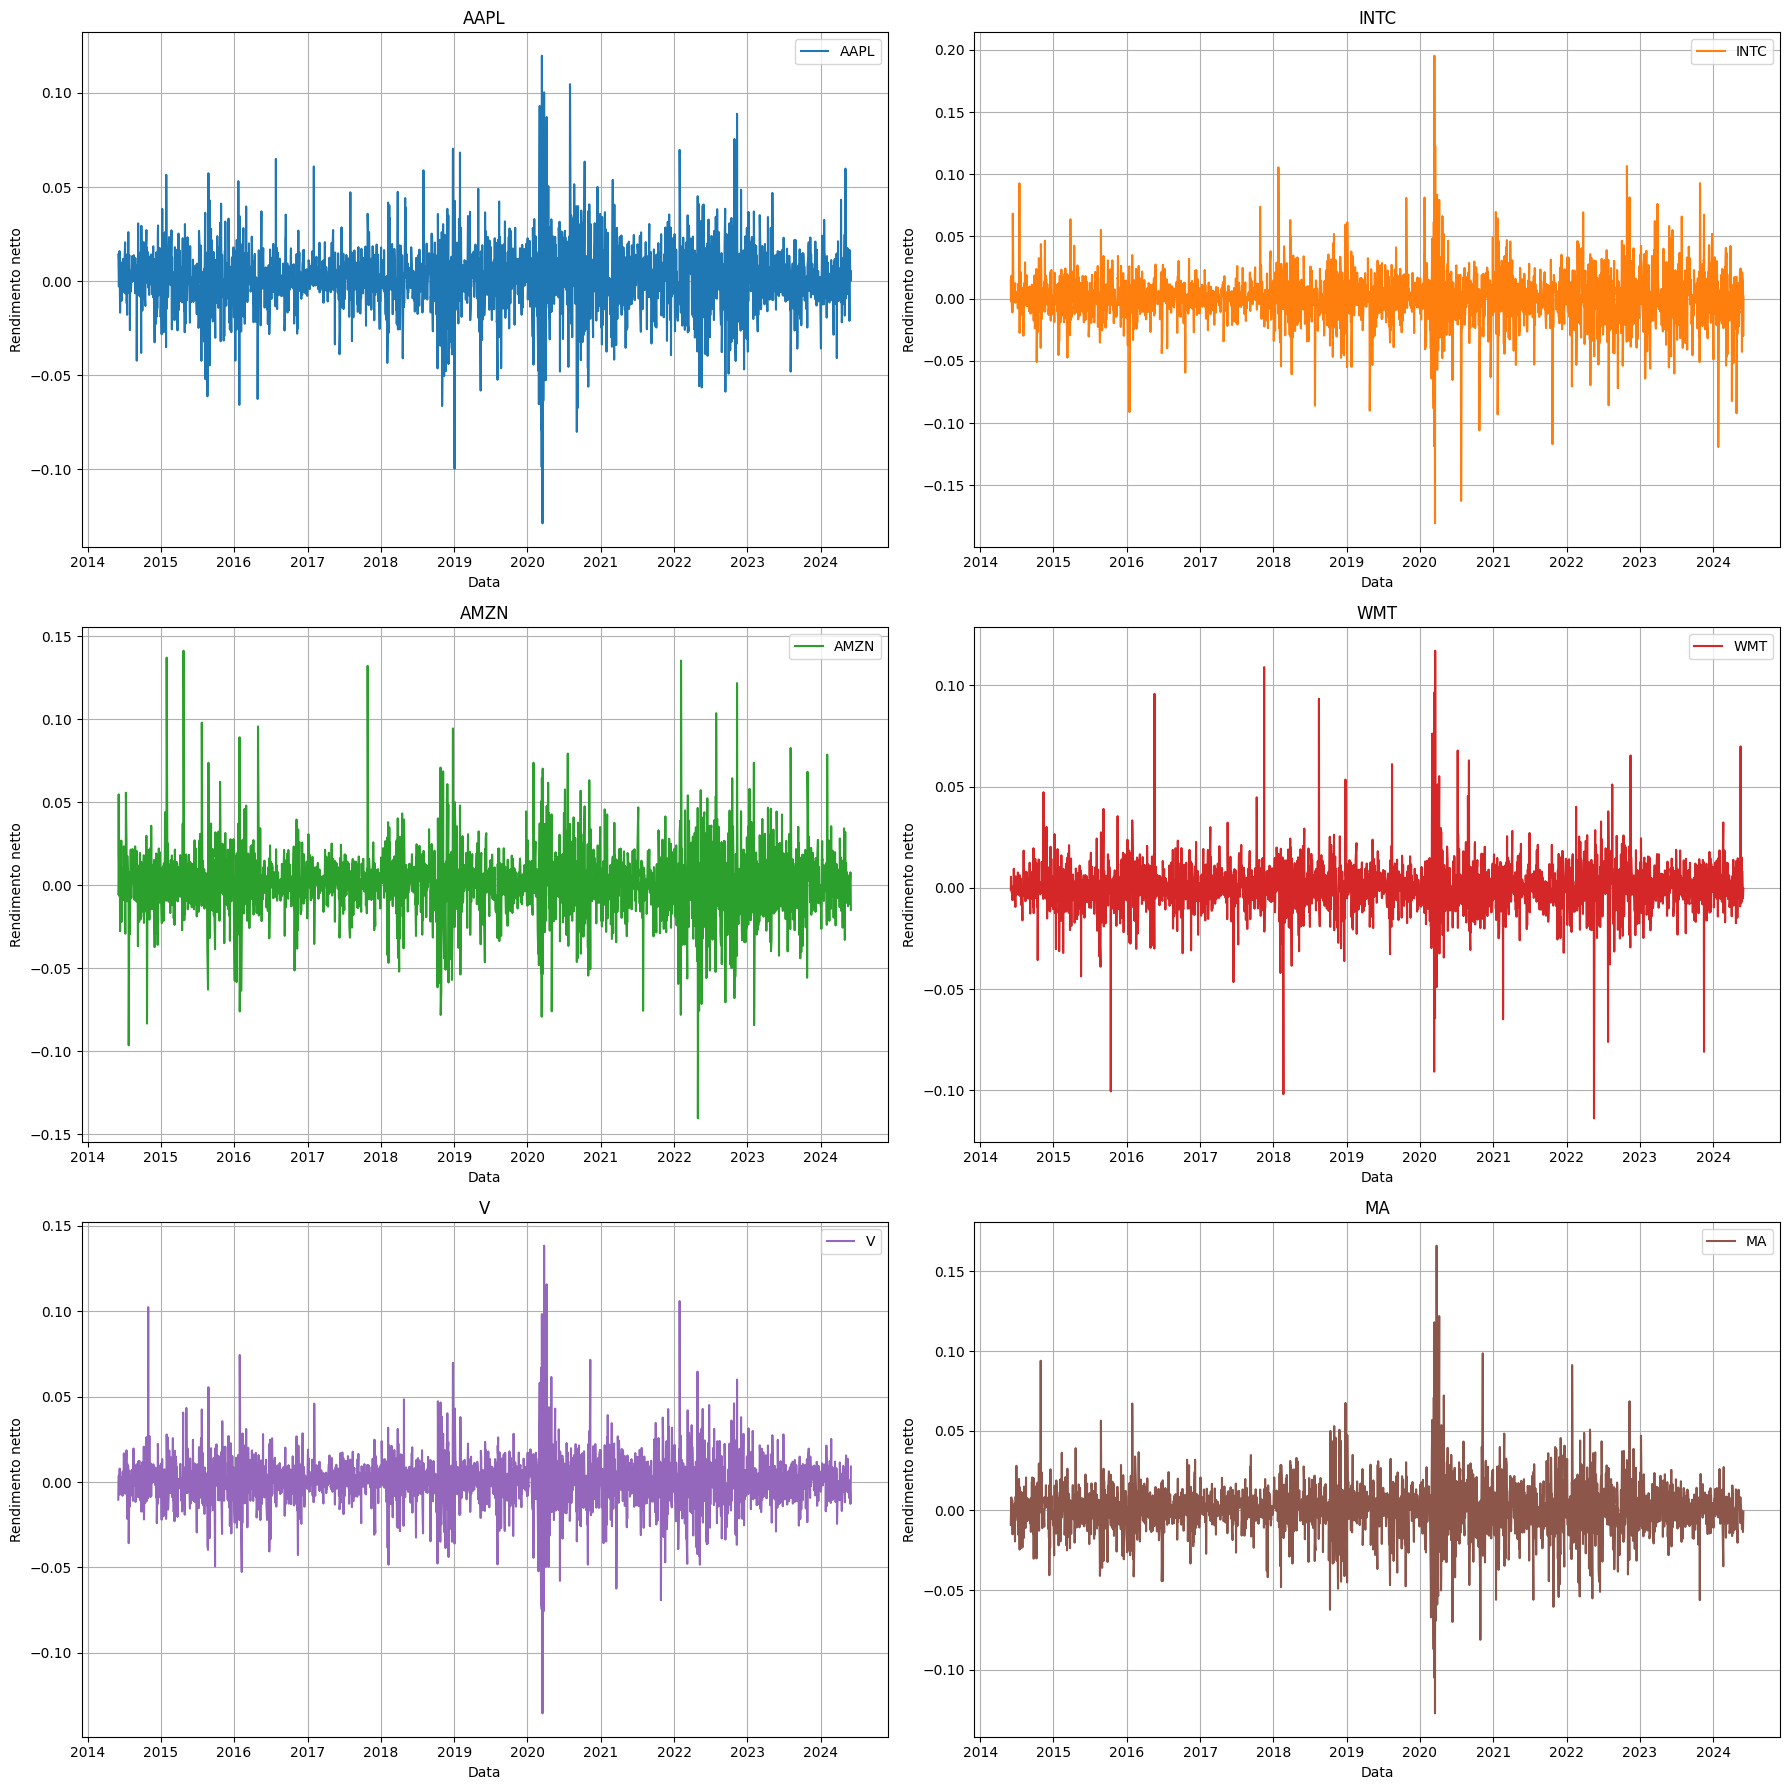

In [165]:
crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto')

In [166]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014142,1.014673,0.994657,0.999349,0.989697,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000520,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003737,1.006813
2014-06-06,0.997251,1.018438,1.018852,0.998578,1.003675,1.008199
2014-06-09,1.016001,0.990770,0.993418,0.997410,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


In [167]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014142,1.014673,0.994657,0.999349,0.989697,0.990915
2014-06-04,1.025722,1.012472,0.993330,1.004820,0.990212,0.990526
2014-06-05,1.029746,1.014673,1.047695,1.007295,0.993912,0.997274
2014-06-06,1.026915,1.033382,1.067446,1.005863,0.997565,1.005451
2014-06-09,1.043347,1.023844,1.060420,1.003257,0.995598,0.997534
...,...,...,...,...,...,...
2024-05-23,9.410156,1.442241,11.724517,3.117381,5.509323,6.228434
2024-05-24,9.566252,1.472926,11.705090,3.143343,5.514546,6.228020
2024-05-28,9.566756,1.489228,11.795751,3.126997,5.444030,6.143817


Visualizziamo l'andamento dei rendimenti cumulati nel corso del tempo.

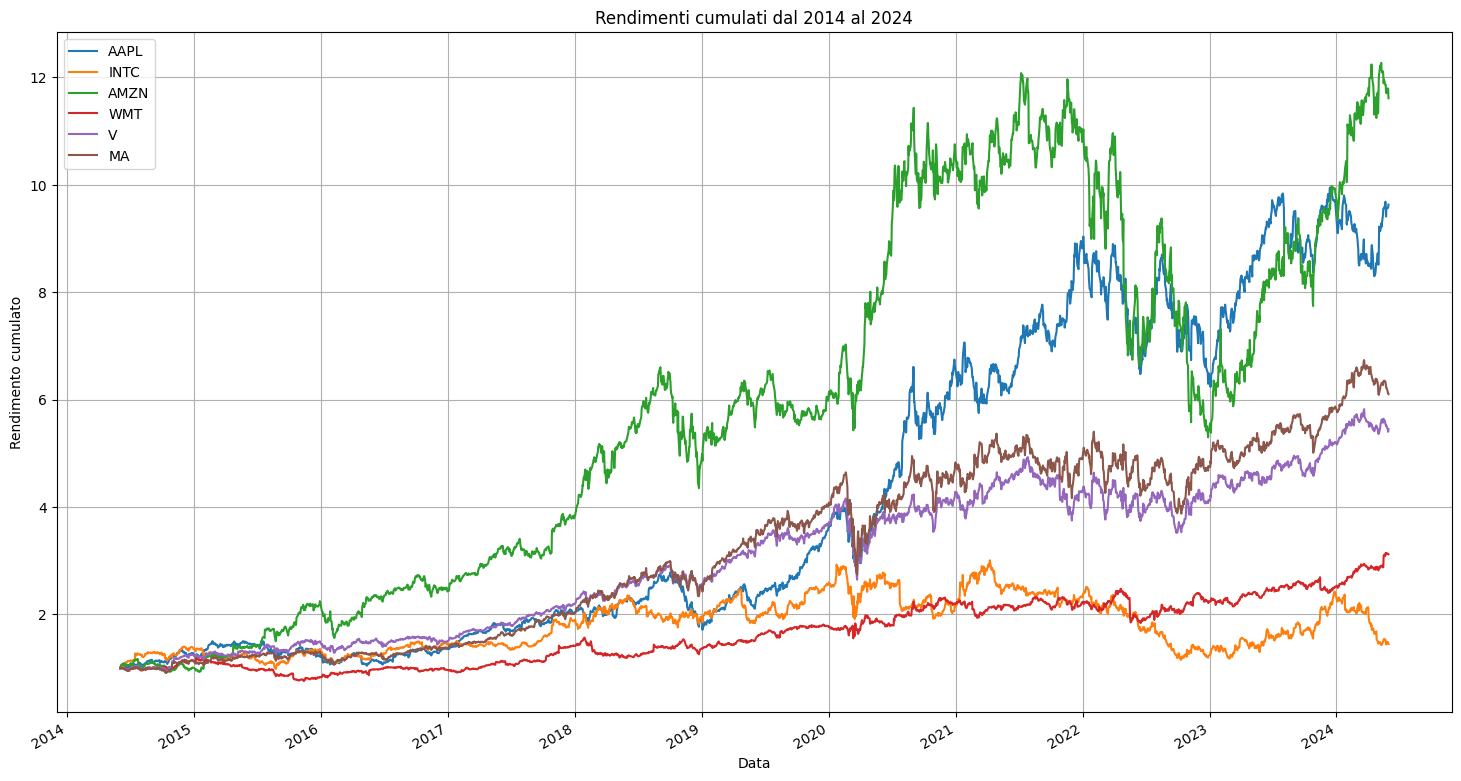

In [168]:
rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Analogamente, visualizziamo l'evoluzione della volatilità nel tempo.

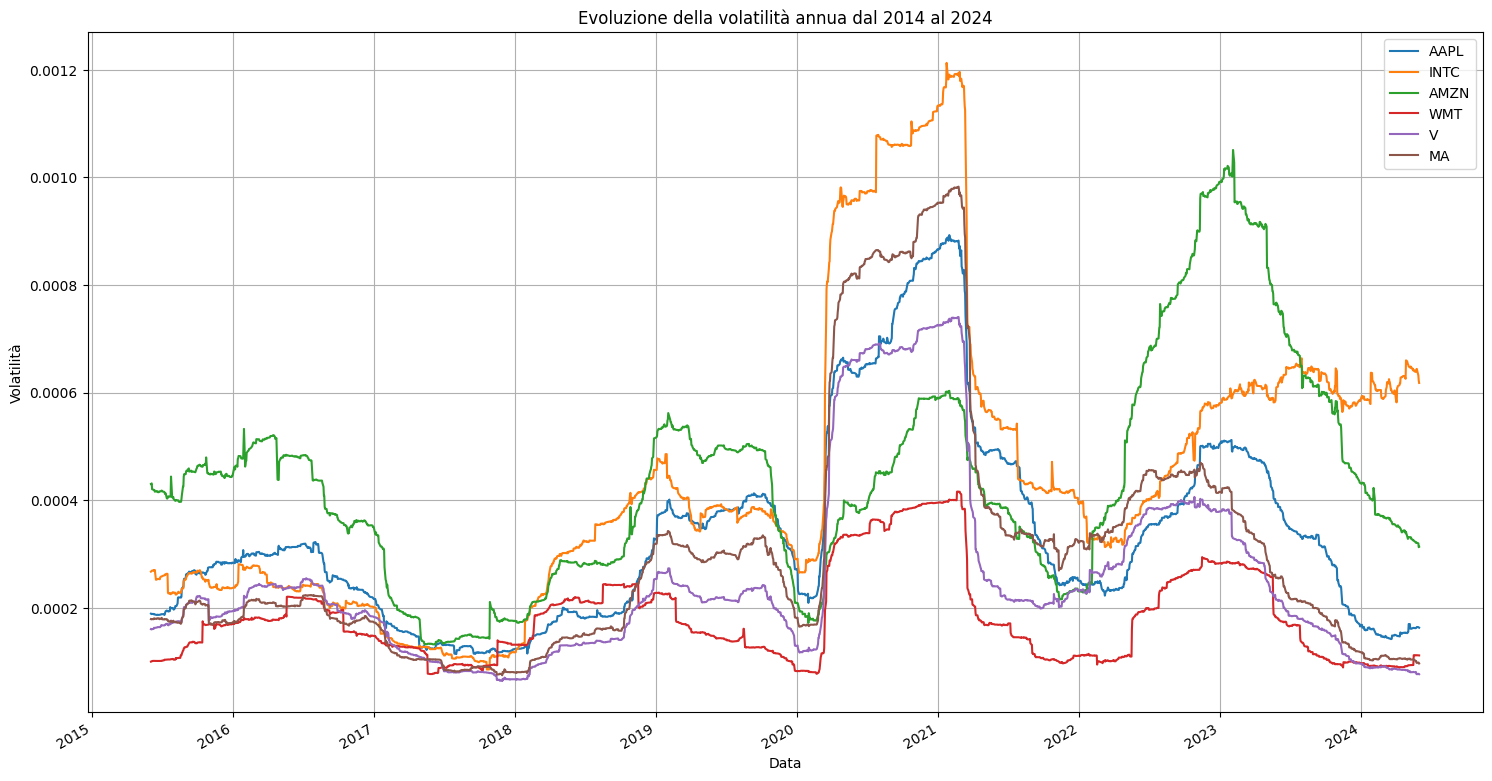

In [169]:
rendimenti_netti_giornalieri.rolling(window=252).var().plot(figsize=(18, 10))
plt.title('Evoluzione della volatilità annua dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [170]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1/numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253984
INTC    0.037646
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

A partire dai rendimenti lordi giornalieri ricaviamo i rendimenti logaritmici.

In [171]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # i rendimenti lordi li ho calcolati in precedenza
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000651,-0.010357,-0.009127
2014-06-04,0.011354,-0.002171,-0.001336,0.005460,0.000520,-0.000393
2014-06-05,0.003916,0.002171,0.053285,0.002460,0.003730,0.006790
2014-06-06,-0.002753,0.018270,0.018677,-0.001423,0.003668,0.008166
2014-06-09,0.015875,-0.009272,-0.006604,-0.002594,-0.001974,-0.007906
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


Vediamo il livello di correlazione che sussiste tra i rendimenti dei titoli appartenenti allo stesso settore.

In [172]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512799
INTC,0.512799,1.000000


In [173]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [174]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000


Visualizziamo come i rendimenti sono distribuiti attraverso degli istogrammi. 

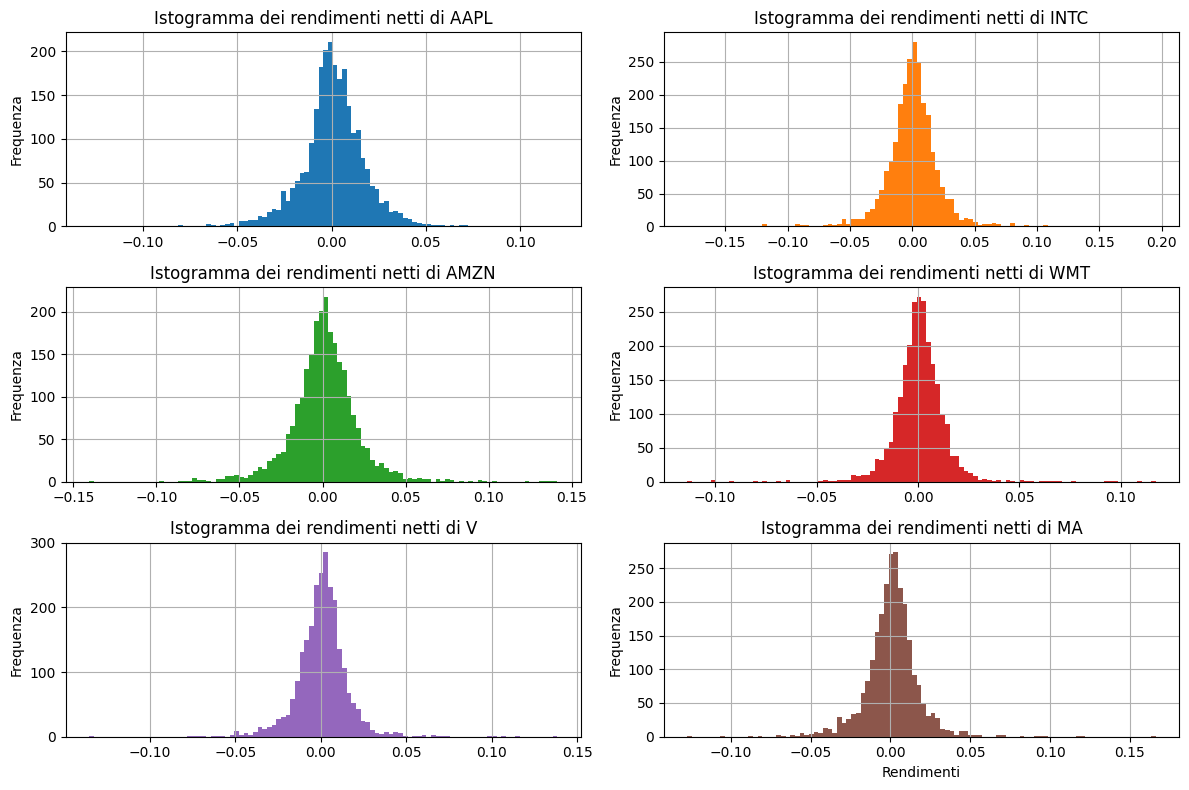

In [175]:
# Numero di colonne per la disposizione degli istogrammi
num_cols = 2
num_rows = int(len(tickers) / num_cols)

# Creazione della figura con sottotrame
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Appiattire gli assi in caso di array bidimensionale
axes = axes.flatten()

# Creazione degli istogrammi con colori personalizzati
for i, ticker in enumerate(tickers):
    color = mappa_colori(i % 10)  # Usa il modulo per assicurarsi di non superare l'indice dei colori disponibili
    rendimenti_netti_giornalieri[ticker].hist(bins=100, ax=axes[i], color=color)
    axes[i].set_title(f'Istogramma dei rendimenti netti di {ticker}')
    axes[i].set_ylabel('Frequenza')

# Rimuovere assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel('Rendimenti')
plt.tight_layout()
plt.show()

Per ciascun titolo visualizziamo i grafici diagnostici a tre sezioni.

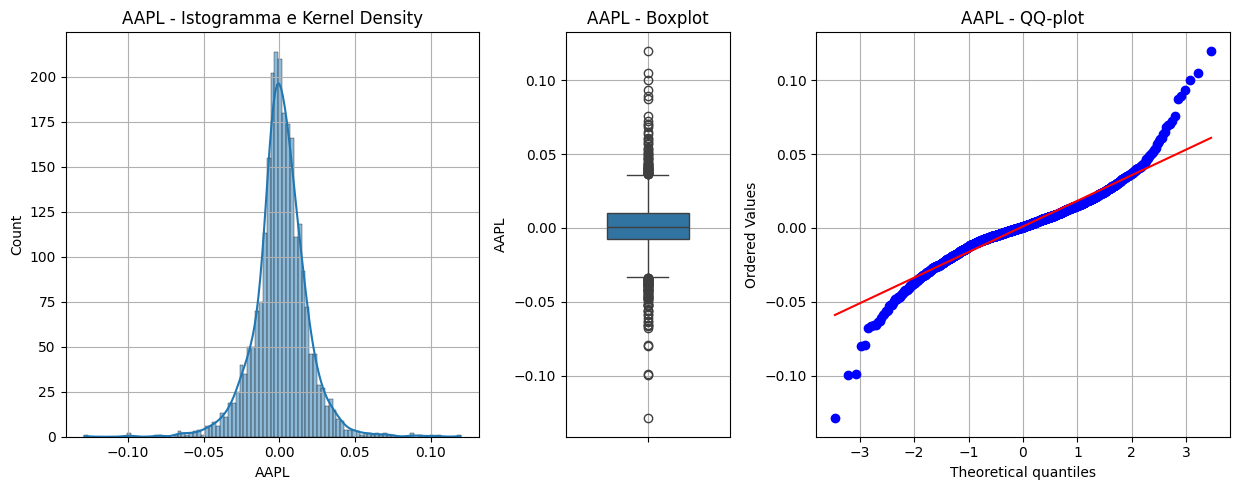

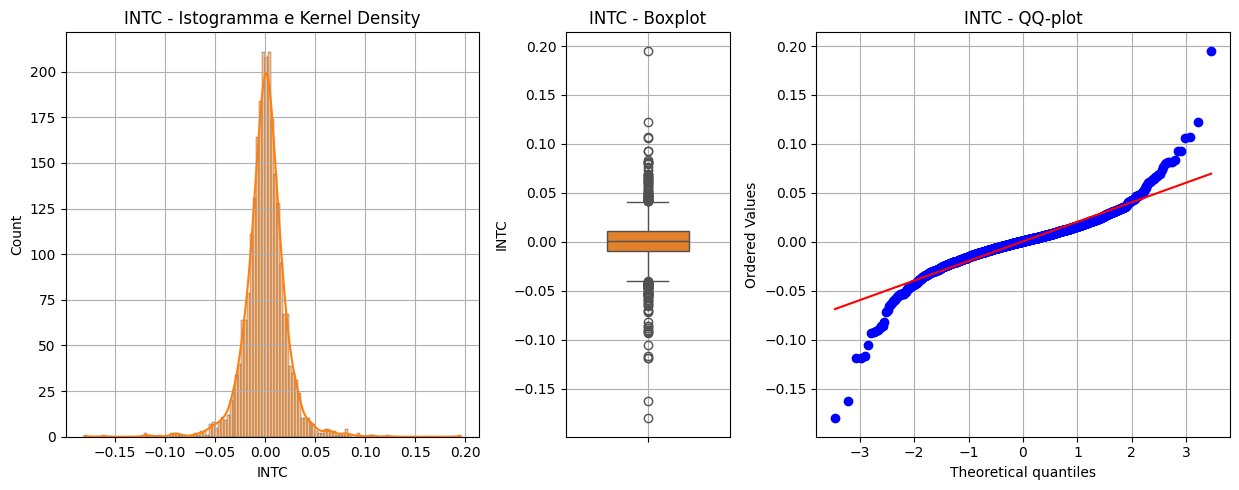

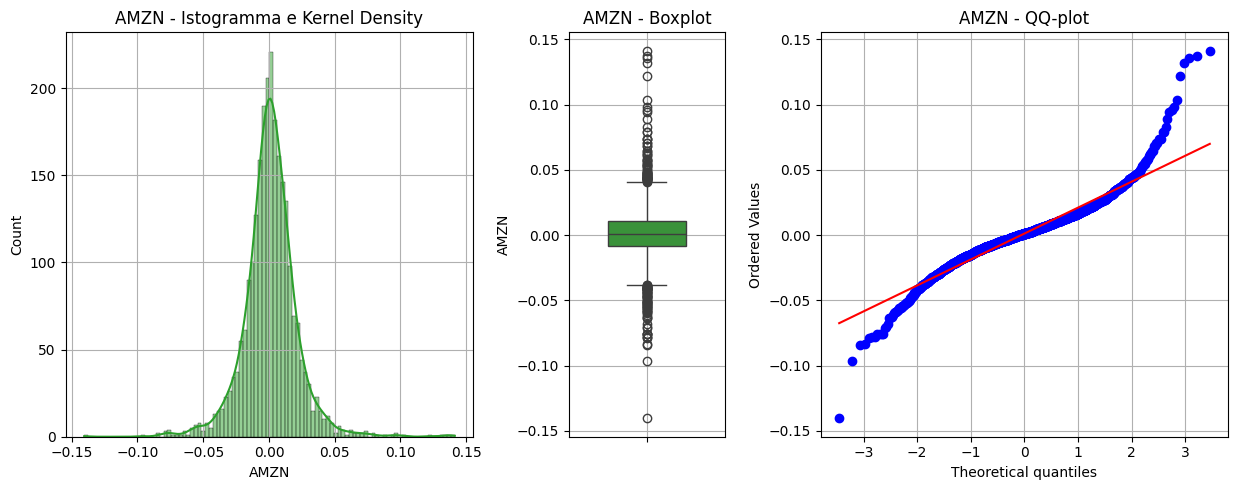

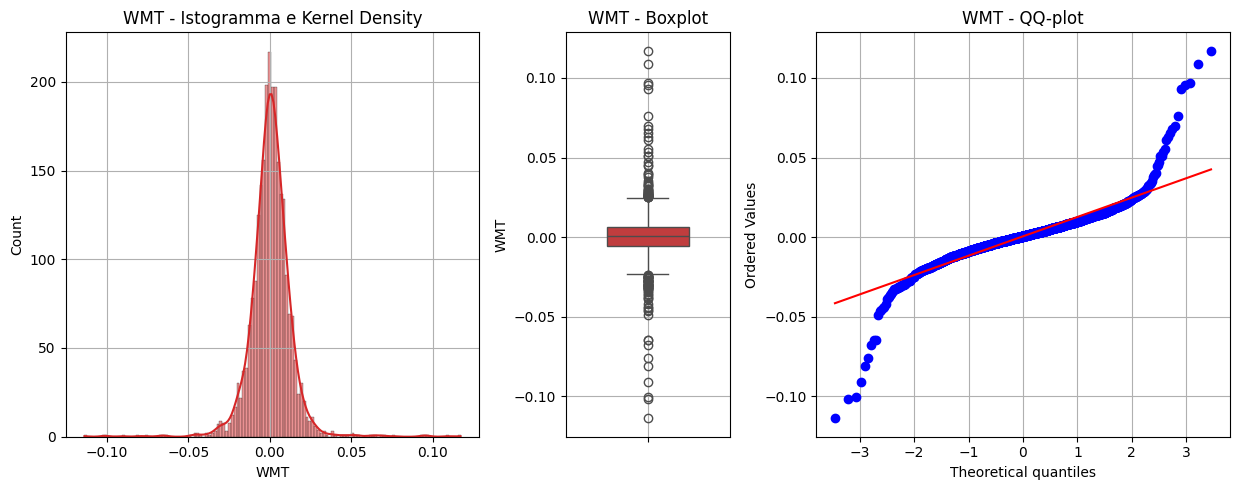

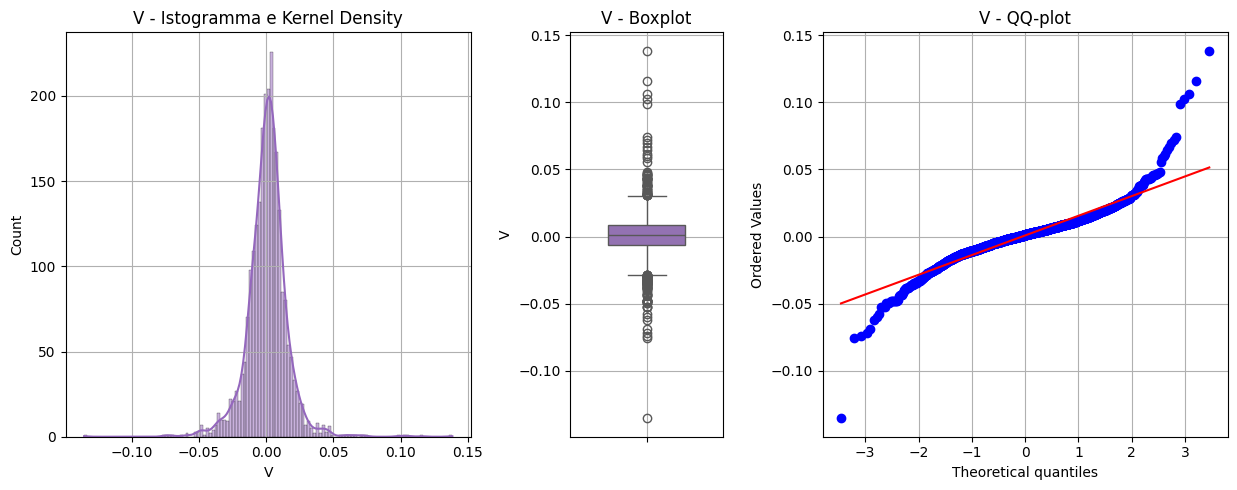

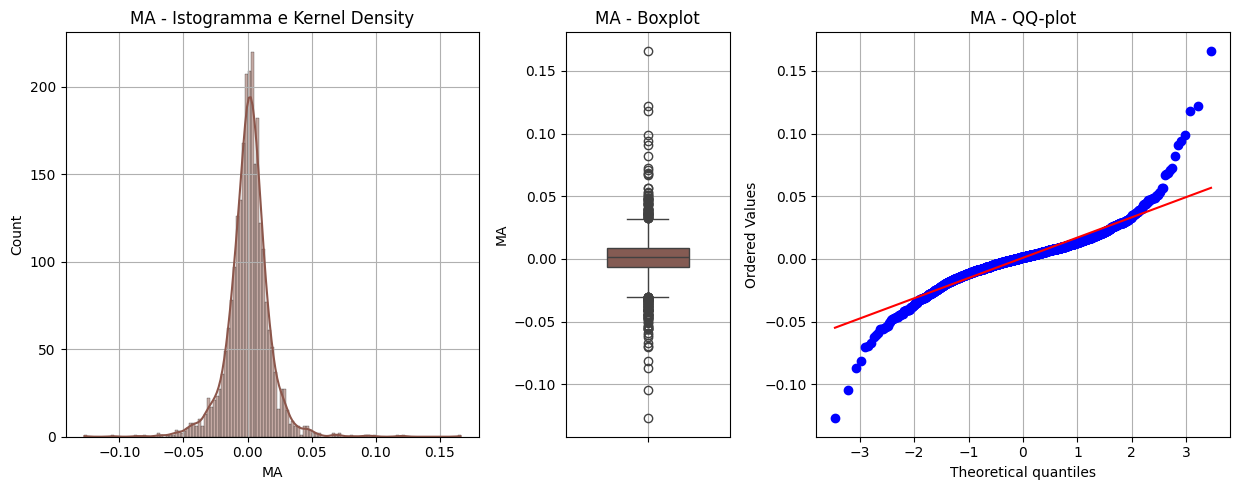

In [176]:
def crea_grafici_diagnostici(dataframe, ticker, colore):
    plt.figure(figsize=(15, 5))

    # Istogramma e kernel density
    plt.subplot2grid((1, 6), (0, 0), colspan=2, rowspan=1)
    sns.histplot(data=dataframe[ticker], kde=True, color=colore)
    plt.title(f'{ticker} - Istogramma e Kernel Density')
    plt.grid(True)

    # Boxplot
    plt.subplot2grid((1, 6), (0, 2), colspan=1, rowspan=1)
    sns.boxplot(data=dataframe[ticker], color=colore, width=0.5)
    plt.title(f'{ticker} - Boxplot')
    plt.grid(True)

    # QQ-plot
    plt.subplot2grid((1, 6), (0, 3), colspan=2, rowspan=1)
    stats.probplot(dataframe[ticker], dist="norm", plot=plt)
    plt.title(f'{ticker} - QQ-plot')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Esegui la funzione per ciascun titolo
for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    crea_grafici_diagnostici(rendimenti_netti_giornalieri, ticker, colore)

Calcoliamo le statistiche descrittive univariate dei rendimenti netti giornalieri.

In [177]:
statistiche_rendimenti_netti_giornalieri = rendimenti_netti_giornalieri.describe()

varianza = pd.Series(rendimenti_netti_giornalieri.var()).to_frame().T
kurtosi = pd.Series(rendimenti_netti_giornalieri.kurtosis()).to_frame().T
skewness = pd.Series(rendimenti_netti_giornalieri.skew()).to_frame().T
varianza.rename(index={0: 'var'}, inplace=True)
kurtosi.rename(index={0: 'kurt'}, inplace=True)
skewness.rename(index={0: 'skew'}, inplace=True)

statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, varianza])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, kurtosi])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, skewness])

statistiche_rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.001060,0.000370,0.001187,0.000539,0.000793,0.000863
std,0.017841,0.021046,0.020638,0.013181,0.015427,0.016970
min,-0.128647,-0.180415,-0.140494,-0.113758,-0.135472,-0.127254
25%,-0.007315,-0.009571,-0.008609,-0.005382,-0.006481,-0.006842
50%,0.000821,0.000795,0.001153,0.000576,0.001316,0.001395
75%,0.010141,0.010663,0.011145,0.006606,0.008236,0.008719
max,0.119808,0.195213,0.141311,0.117085,0.138426,0.166109
var,0.000318,0.000443,0.000426,0.000174,0.000238,0.000288
kurt,5.360826,10.311218,6.337522,16.261149,10.399221,10.021953


Ora vediamo la matrice di covarianza e la matrice di correlazione.

In [178]:
rendimenti_netti_giornalieri.cov() # matrice di covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.000318,0.000193,0.000203,0.000075,0.000158,0.000178
INTC,0.000193,0.000443,0.000173,0.000076,0.000150,0.000169
AMZN,0.000203,0.000173,0.000426,0.000068,0.000149,0.000169
WMT,0.000075,0.000076,0.000068,0.000174,0.000059,0.000064
V,0.000158,0.000150,0.000149,0.000059,0.000238,0.000234
MA,0.000178,0.000169,0.000169,0.000064,0.000234,0.000288


In [179]:
rendimenti_netti_giornalieri.corr() # matrice di correlazione

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,1.000000,0.512799,0.551232,0.320545,0.572280,0.586874
INTC,0.512799,1.000000,0.397253,0.274462,0.461147,0.474220
AMZN,0.551232,0.397253,1.000000,0.250431,0.466580,0.483197
WMT,0.320545,0.274462,0.250431,1.000000,0.289392,0.284193
V,0.572280,0.461147,0.466580,0.289392,1.000000,0.895385
MA,0.586874,0.474220,0.483197,0.284193,0.895385,1.000000


Vediamo com'è stato l'andamento nel tempo della correlazione tra titoli dello stesso settore.

In [180]:
def andamento_correlazione_rendimenti(tickers_settore, nome_settore, colore):
    # Calcola la correlazione tra i titoli del settore
    correlazione = rendimenti_netti_giornalieri[tickers_settore[0]].rolling(window=252).corr(rendimenti_netti_giornalieri[tickers_settore[1]])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    correlazione.plot(label=nome_settore, ax=ax, color=colore)

    ax.axhline(rendimenti_netti_giornalieri.corr().loc[tickers_settore[0], tickers_settore[1]], c='r')
    plt.legend()
    plt.title(f'Andamento della correlazione nel tempo dei titoli per il settore {nome_settore}')
    plt.xlabel('Data')
    plt.ylabel('Correlazione')
    plt.grid(True)
    plt.show()

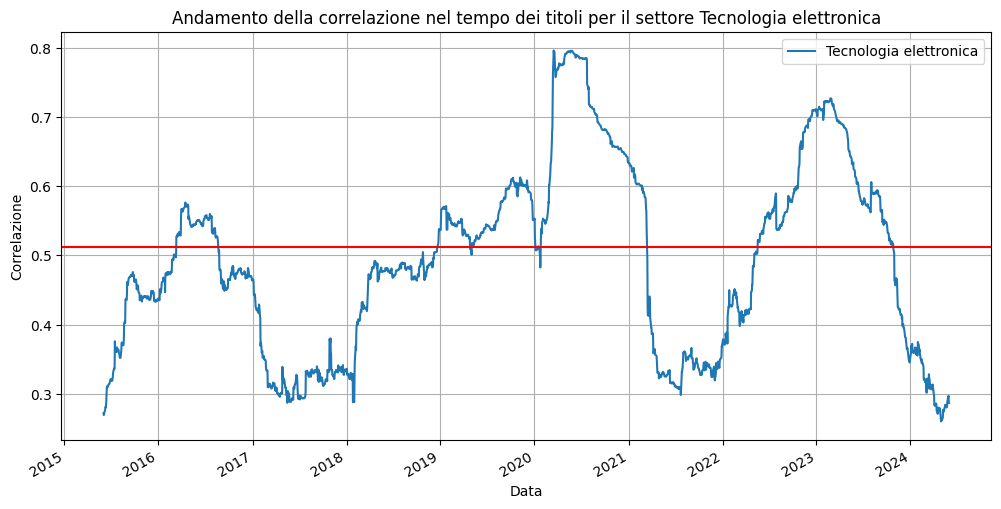

In [181]:
andamento_correlazione_rendimenti(tickers_settore1, settore_1, mappa_colori(0))

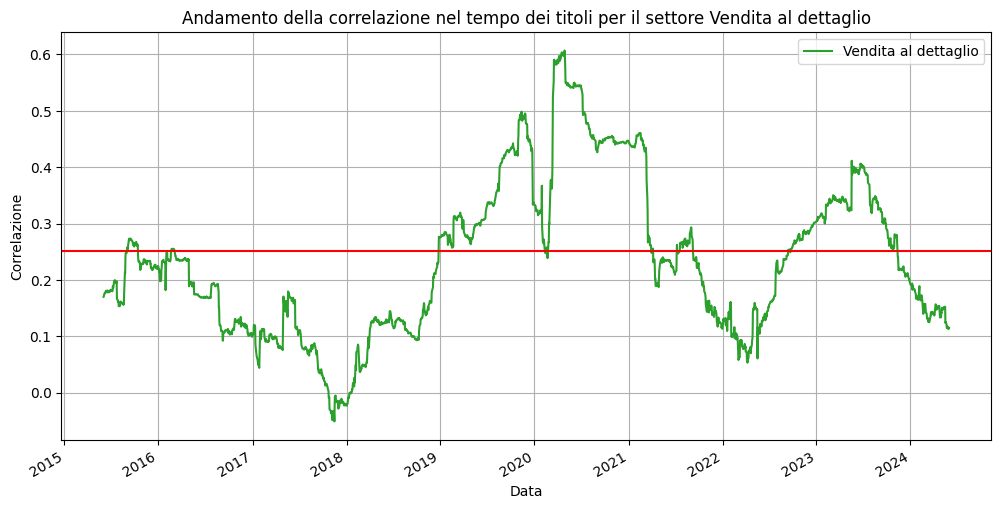

In [182]:
andamento_correlazione_rendimenti(tickers_settore2, settore_2, mappa_colori(2))

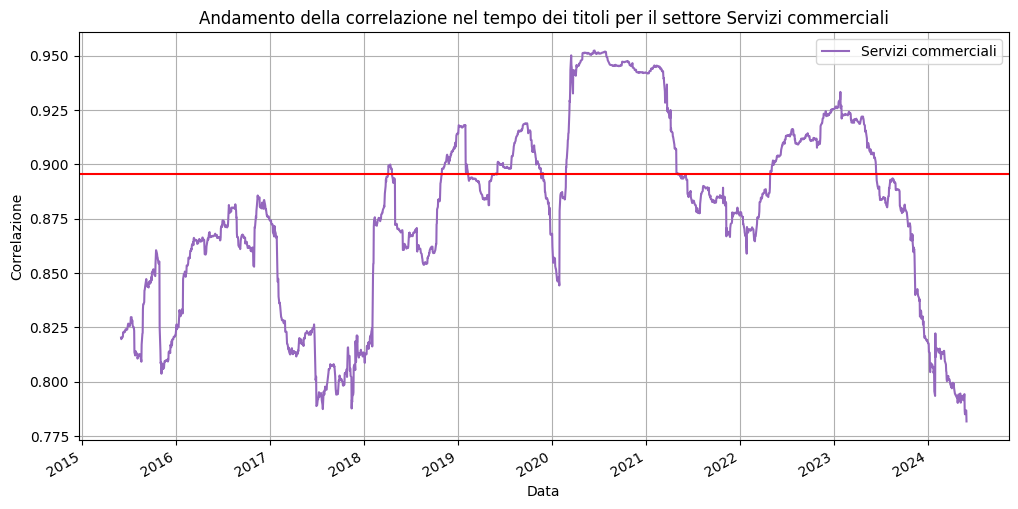

In [183]:
andamento_correlazione_rendimenti(tickers_settore3, settore_3, mappa_colori(4))

Attraverso degli scatter plot osserviamo la dispersione dei rendimenti mettendo a confronto i titoli dello stesso settore. 

In [184]:
colore_neutro_chiaro = '#333333'
colore_neutro_scuro = '#666666'
def crea_scatter_plot(dataframe, settore):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(dataframe[settore[0]], dataframe[settore[1]], color=colore_neutro_chiaro)
    ax.set_xlim(min(dataframe[settore[0]]), max(dataframe[settore[1]]))
    ax.autoscale(False)
    ax.vlines(0, -10, 10, color=colore_neutro_scuro)
    ax.hlines(0, -10, 10, color=colore_neutro_scuro)
    ax.plot((-10,10),(-10,10), color=colore_neutro_scuro)
    ax.set_xlabel(settore[0])
    ax.set_ylabel(settore[1])
    plt.grid(True)

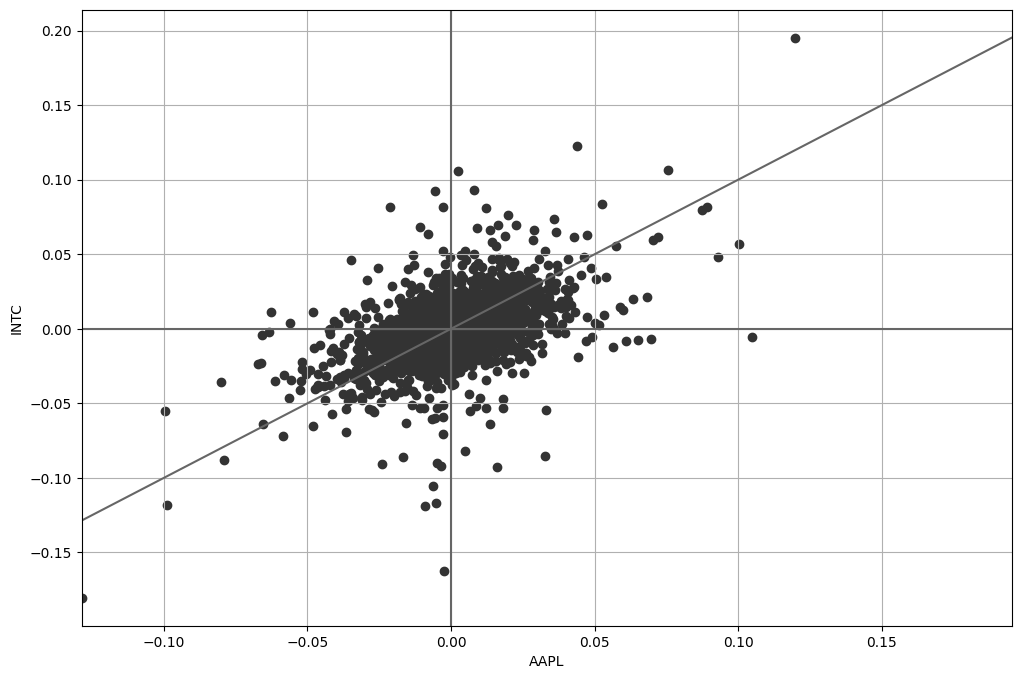

In [185]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore1)

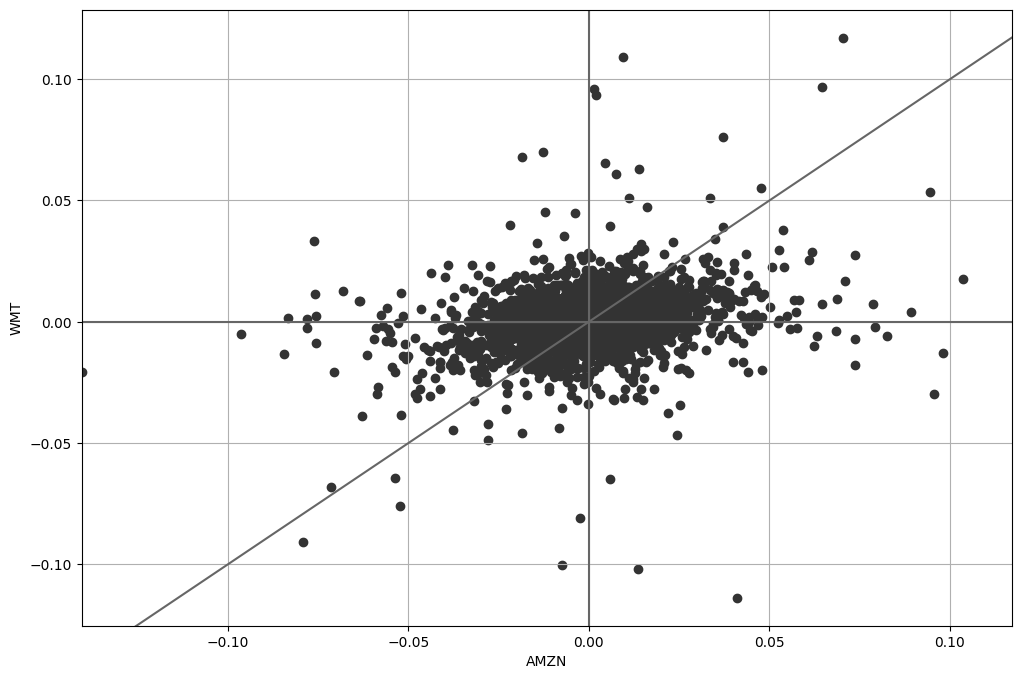

In [186]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore2)

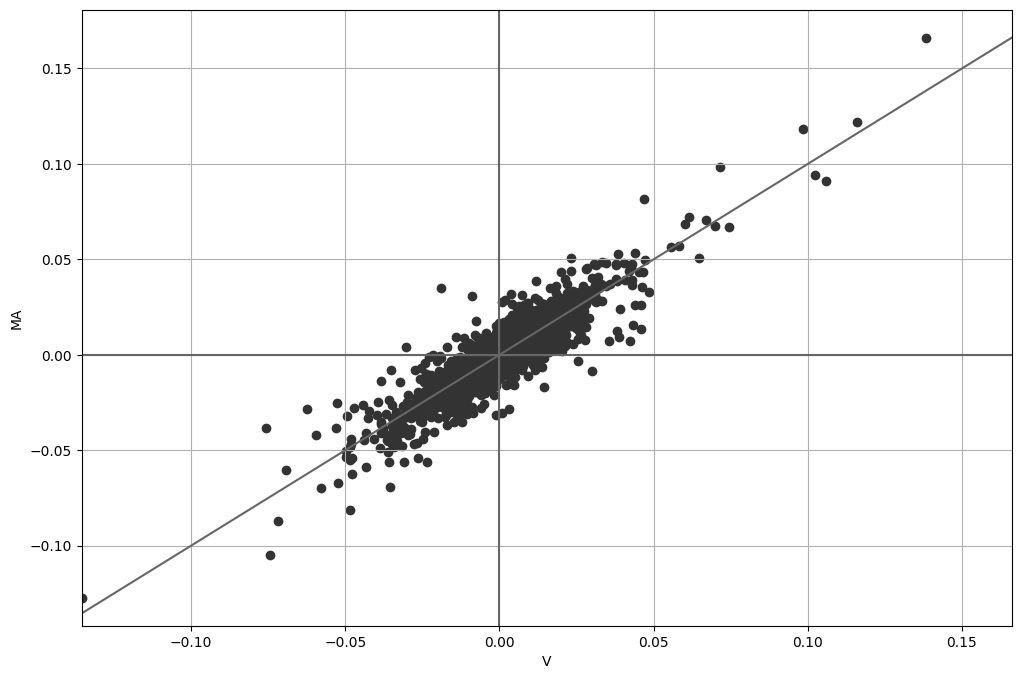

In [187]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore3)

## Strategie di trading e backtesting

Procediamo ora con la costruzione di una strategia di trading. <br>
L'idea che si vuole analizzare è quella di combinare l'utilizzo delle medie mobili esponenziali e dell'indice RSI per generare segnali d'acquisto: utilizzando entrambi gli indicatori è possibile tenere conto sia del trend (catturato dalle medie mobili esponenziali) sia del momentum (catturato dall'indice RSI).

In [188]:
ticker_strategia = 'MA'
indicatori_trading  = prezzi_chiusura_giornalieri[ticker_strategia].copy()
indicatori_trading.rename('Chiusura aggiustata', inplace=True)
indicatori_trading = indicatori_trading.to_frame()

indicatori_trading['EMA20'] = indicatori_trading['Chiusura aggiustata'].ewm(span=20, adjust=False).mean() # calcolo la media mobile esponenziale a 20 giorni
indicatori_trading['EMA50'] = indicatori_trading['Chiusura aggiustata'].ewm(span=50, adjust=False).mean() # calcolo la media mobile esponenziale a 50 giorni

In [189]:
def calcola_RSI(data, window=14):
    delta = data['Chiusura aggiustata'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

indicatori_trading['RSI'] = calcola_RSI(indicatori_trading) # calcolo l'indice RSI
indicatori_trading.dropna(inplace=True)

indicatori_trading

,Chiusura aggiustata,EMA20,EMA50,RSI
Date,,,,
2014-06-19,69.829781,71.584138,72.034416,29.559123
2014-06-20,69.397263,71.375864,71.930998,27.686171
2014-06-23,69.707550,71.216977,71.843804,33.962582
2014-06-24,68.353615,70.944276,71.706934,28.193041
2014-06-25,68.673294,70.727992,71.587968,26.601392
...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337
2024-05-24,451.179993,456.221364,458.648889,53.338249
2024-05-28,445.079987,455.160281,458.116776,36.483716


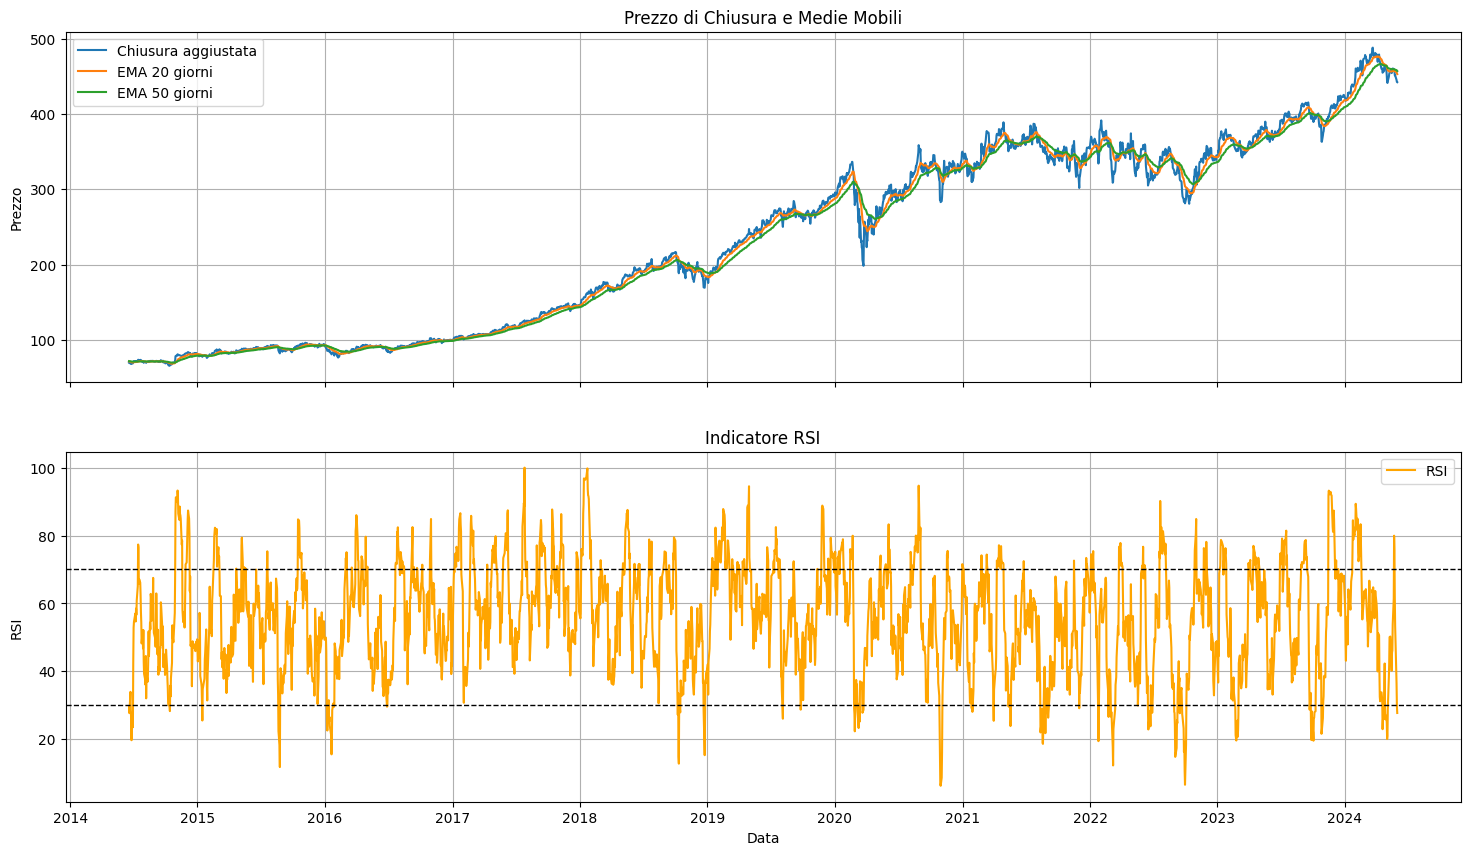

In [190]:
# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Grafico del prezzo di chiusura e delle medie mobili
ax1.plot(indicatori_trading.index, indicatori_trading['Chiusura aggiustata'], label='Chiusura aggiustata')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA20'], label='EMA 20 giorni')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA50'], label='EMA 50 giorni')
ax1.set_title('Prezzo di Chiusura e Medie Mobili')
ax1.set_ylabel('Prezzo')
ax1.legend()
ax1.grid(True)

# Grafico dell'indicatore RSI
ax2.plot(indicatori_trading.index, indicatori_trading['RSI'], label='RSI', color='orange')
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(30, color='black', linestyle='--', linewidth=1)
ax2.set_title('Indicatore RSI')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True)

plt.show()

Dopo aver calcolato gli indicatori di cui abbiamo bisogno, procediamo con l'applicazione della strategia.

Secondo la strategia viene generato un __segnale di acquisto__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dal basso verso l'alto la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al rialzo
- l'indice RSI supera 50, confermando che il trend rialzista è abbastanza intenso

Secondo la strategia viene generato un __segnale di vendita__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dall'alto verso il basso la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al ribasso
- l'indice RSI scende sotto 50, confermando che il trend ribassista è abbastanza intenso

In [191]:
strategia_trading = indicatori_trading.copy()

condizione_acquisto = ((strategia_trading['EMA20'] > strategia_trading['EMA50']) &
                       (strategia_trading['RSI'] > 50))
                      
condizione_vendita = ((strategia_trading['EMA20'] < strategia_trading['EMA50']) &
                      (strategia_trading['RSI'] < 50))

# Crea la colonna "Posizione" e assegna i valori in base alle condizioni
strategia_trading['Posizione'] = 0  # Inizializza tutte le posizioni a 0

# Imposta le posizioni a 1 quando si verifica la condizione di acquisto
strategia_trading.loc[condizione_acquisto, 'Posizione'] = 1

# Imposta le posizioni a 1 quando si verifica la condizione di vendita
strategia_trading.loc[condizione_vendita, 'Posizione'] = 0

strategia_trading

,Chiusura aggiustata,EMA20,EMA50,RSI,Posizione
Date,,,,,
2014-06-19,69.829781,71.584138,72.034416,29.559123,0
2014-06-20,69.397263,71.375864,71.930998,27.686171,0
2014-06-23,69.707550,71.216977,71.843804,33.962582,0
2014-06-24,68.353615,70.944276,71.706934,28.193041,0
2014-06-25,68.673294,70.727992,71.587968,26.601392,0
...,...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337,0
2024-05-24,451.179993,456.221364,458.648889,53.338249,0
2024-05-28,445.079987,455.160281,458.116776,36.483716,0


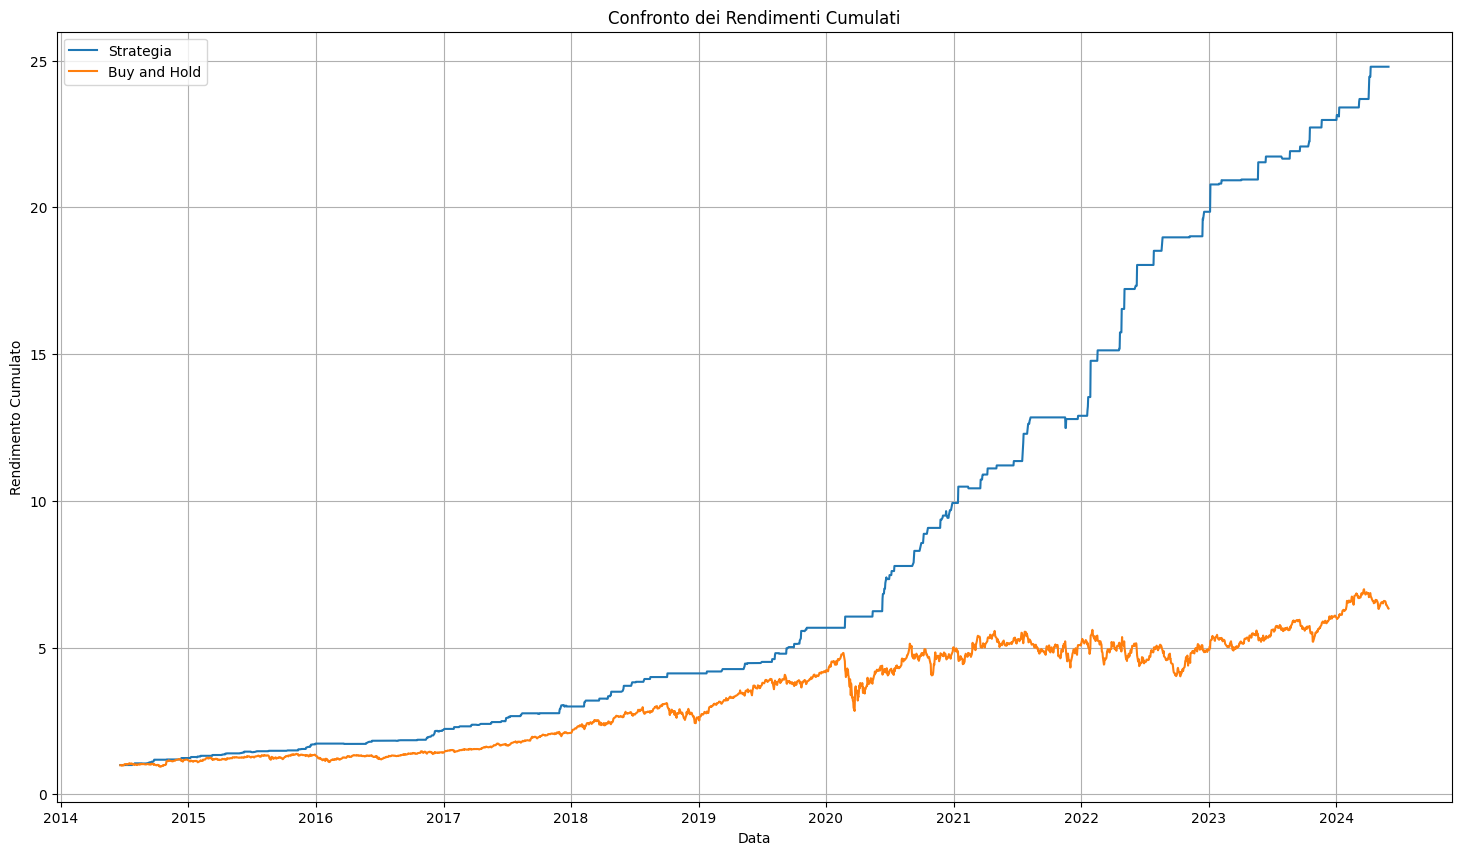

In [192]:
# Calcola i rendimenti cumulati delle due strategie # TODO: STRATEGIA DI CALCOLO DI CHATGPT
rendimenti_cumulati = (1 + strategia_trading['Posizione'].diff() * strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()
rendimento_cumulato_buy_and_hold = (1 + strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()

# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(rendimenti_cumulati, label='Strategia')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

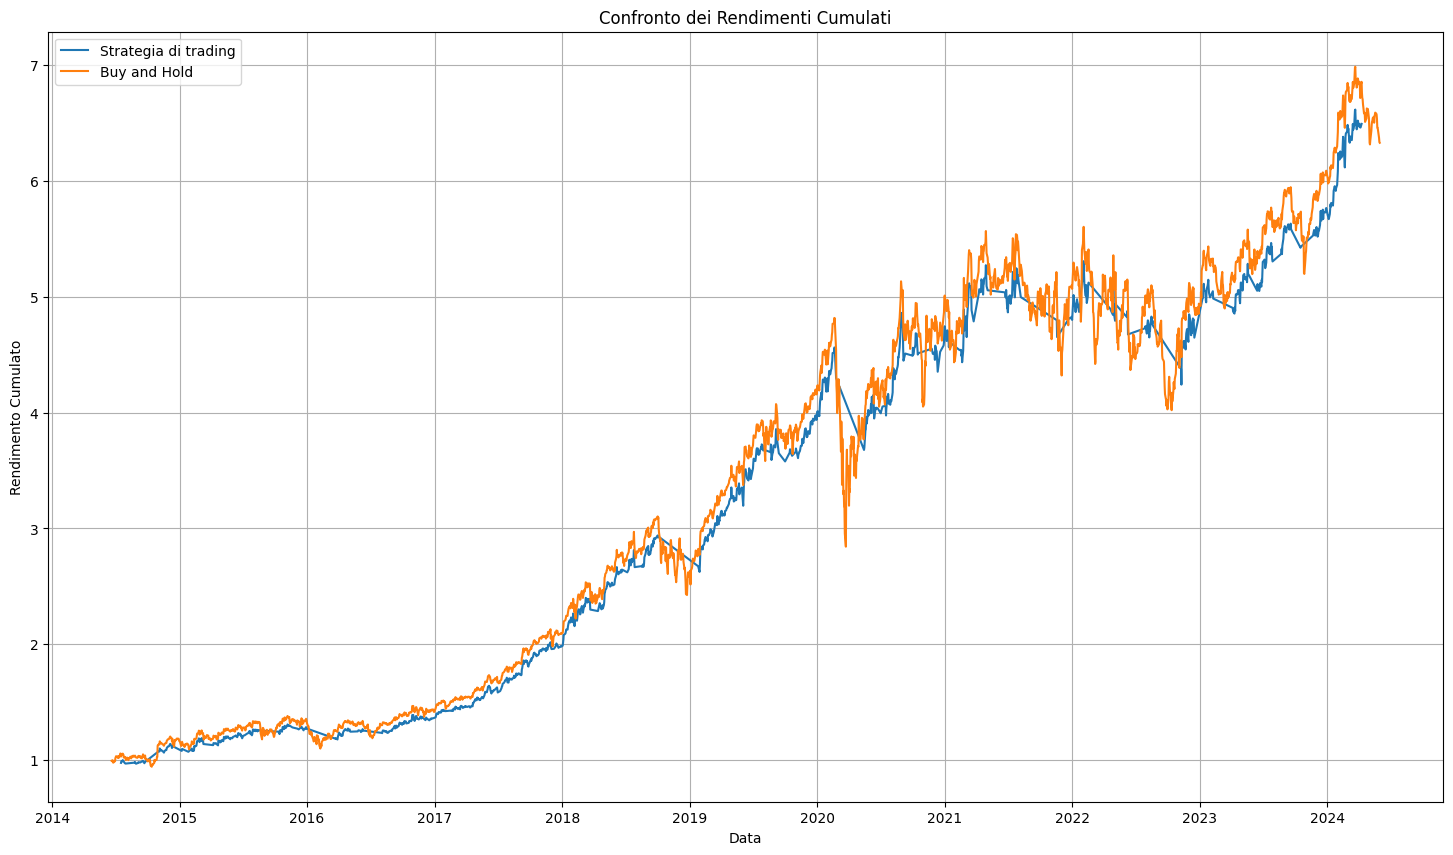

In [193]:
# TODO: STRATEGIA DI CALCOLO DEL PROF

risultati_strategia_trading = strategia_trading[strategia_trading['Posizione'] == 1].copy()
risultati_strategia_trading['Rendimento cumulato'] = np.cumprod(risultati_strategia_trading['Chiusura aggiustata'] /
                                                                risultati_strategia_trading['Chiusura aggiustata'].shift(1))
# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(risultati_strategia_trading['Rendimento cumulato'], label='Strategia di trading')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

## CAPM

Arriviamo quindi alla sezione dedicata al Capital Asset Pricing Model.

Per prima cosa scarichiamo i dati mensili relativi al modello di Fama e French: in questo modo possiamo sfruttare i dati relativi ai tassi risk-free mensili.

In [194]:
# popoliamo un dataframe con i dati di fama e french mensili
fama_french_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
fama_french_mensile.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
fama_french_mensile.set_index('Date', inplace = True)
fama_french_mensile = fama_french_mensile.loc[inizio: fine] # filtriamo per il periodo di interesse

fama_french_mensile = fama_french_mensile.tail(-2) # rimuovo le prime due righe per allinearlo al dataframe CAPM
fama_french_mensile

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-07-31,-0.0204,-0.0429,0.0003,0.0000
2014-08-31,0.0424,0.0040,-0.0045,0.0000
2014-09-30,-0.0197,-0.0371,-0.0134,0.0000
2014-10-31,0.0252,0.0421,-0.0181,0.0000
2014-11-30,0.0255,-0.0206,-0.0309,0.0000
...,...,...,...,...
2023-12-31,0.0487,0.0634,0.0493,0.0043
2024-01-31,0.0070,-0.0509,-0.0238,0.0047
2024-02-29,0.0506,-0.0024,-0.0349,0.0042


Dopodiché scarichiamo i dati relativi al mercato (indice S&P500), ne calcoliamo il rendimento netto mensile e il premio di mercato.

In [195]:
# scarichiamo da yahoo finance i prezzi di chiusura dell'indice S&P500
sp500 = prendi_dati_titolo('^GSPC', inizio, fine)
sp500.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
sp500.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# ricampioniamo i prezzi su base mensile (prendendo l'ultimo giorno di ciascun mese)
sp500 = sp500.resample("ME").last()

sp500['Rendimento netto mensile'] = sp500['Chiusura aggiustata'].pct_change()
sp500.dropna(inplace=True)

sp500['Premio di mercato'] = sp500['Rendimento netto mensile'] - fama_french_mensile['RF']

sp500

,Chiusura aggiustata,Rendimento netto mensile,Premio di mercato
Date,,,
2014-07-31,1930.670044,-0.015080,-0.015080
2014-08-31,2003.369995,0.037655,0.037655
2014-09-30,1972.290039,-0.015514,-0.015514
2014-10-31,2018.050049,0.023201,0.023201
2014-11-30,2067.560059,0.024534,0.024534
...,...,...,...
2024-01-31,4845.649902,0.015896,0.011196
2024-02-29,5096.270020,0.051721,0.047521
2024-03-31,5254.350098,0.031019,0.026719


Andiamo poi a comporre un dataframe che raccoglie per ciascun titolo il prezzo di chiusura aggiustato, il rendimento netto mensile ed il premio di rischio.

In [196]:
dati_mensili_titoli = dataframe_completo.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dati_mensili_titoli.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# trasformiamo le date in oggetti datetime facilmente manipolabili da pandas
dati_mensili_titoli.index = dati_mensili_titoli.index.set_levels(pd.to_datetime(dati_mensili_titoli.index.levels[1]), level=1)

# per ciascun ticker, ricampioniamo il dataframe su base mensile
dati_mensili_titoli = dati_mensili_titoli.groupby('Ticker').resample('ME', level=1).last()

# calcoliamo il rendimento netto mensile
dati_mensili_titoli['Rendimento netto mensile'] = dati_mensili_titoli.groupby('Ticker')['Chiusura aggiustata'].pct_change()
dati_mensili_titoli = dati_mensili_titoli.dropna()

dati_mensili_titoli['Premio di rischio'] = dati_mensili_titoli['Rendimento netto mensile'] - fama_french_mensile['RF']

dati_mensili_titoli

Chiusura aggiustata  Rendimento netto mensile  \
Ticker Date                                                        
AAPL   2014-07-31            21.140392                  0.028731   
       2014-08-31            22.778959                  0.077509   
       2014-09-30            22.390053                 -0.017073   
       2014-10-31            24.001242                  0.071960   
       2014-11-30            26.544863                  0.105979   
...                                ...                       ...   
WMT    2024-01-31            54.707005                  0.048208   
       2024-02-29            58.209579                  0.064024   
       2024-03-31            59.962444                  0.030113   
       2024-04-30            59.145275                 -0.013628   
       2024-05-31            64.889999                  0.097129   

                   Premio di rischio  
Ticker Date                           
AAPL   2014-07-31           0.028731  
       2014-08-31           0.077509  
       2014-09-30          -0.017073  
       2014-10-31           0.071960  
       2014-11-30           0.105979  
...                              ...  
WMT    2024-01-31           0.043508  
       2024-02-29           0.059824  
       2024-03-31           0.025813  
       2024-04-30          -0.018328  
       2024-05-31                NaN  

[714 rows x 3 columns]

Definiamo quindi una funzione per effettuare la regressione e stimare il modello.

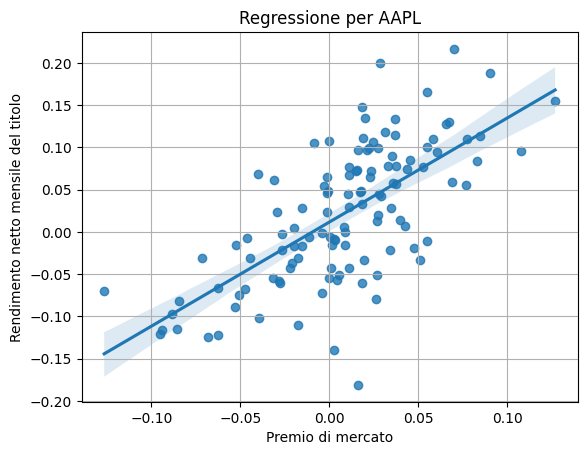

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0115,0.006,2.086,0.039,0.001,0.022
Premio di mercato,1.2332,0.123,9.994,0.000,0.989,1.478


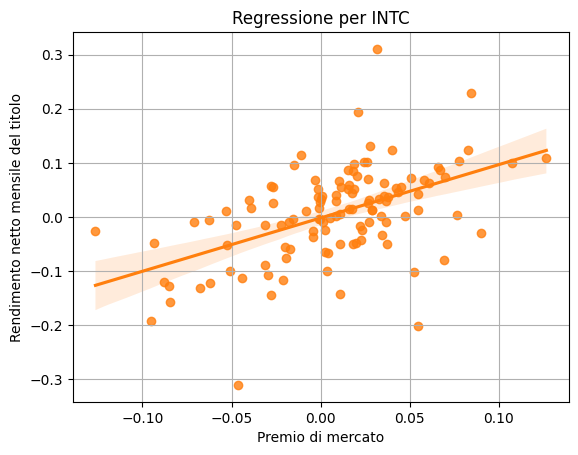

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0018,0.007,-0.259,0.796,-0.016,0.012
Premio di mercato,0.9842,0.156,6.317,0.000,0.676,1.293


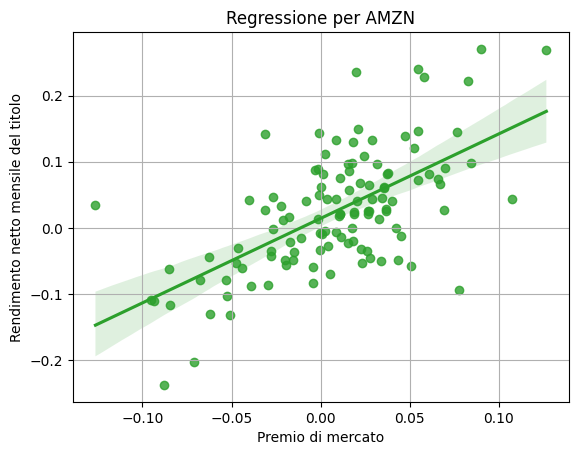

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0142,0.007,2.157,0.033,0.001,0.027
Premio di mercato,1.2768,0.147,8.667,0.000,0.985,1.569


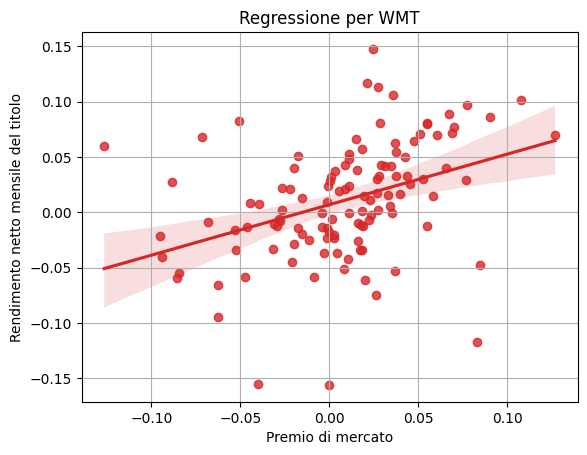

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0069,0.005,1.506,0.135,-0.002,0.016
Premio di mercato,0.4574,0.102,4.497,0.000,0.256,0.659


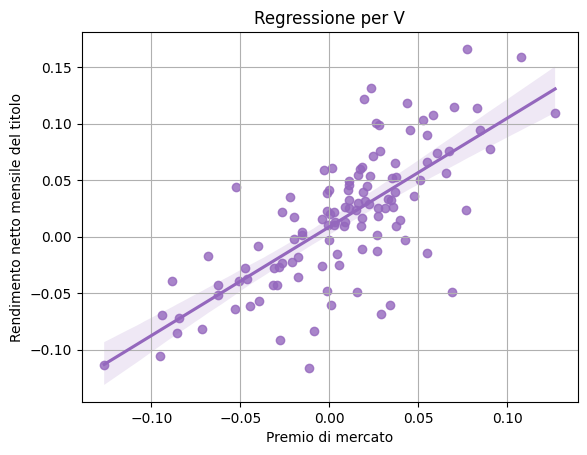

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0086,0.004,2.270,0.025,0.001,0.016
Premio di mercato,0.9626,0.085,11.385,0.000,0.795,1.130


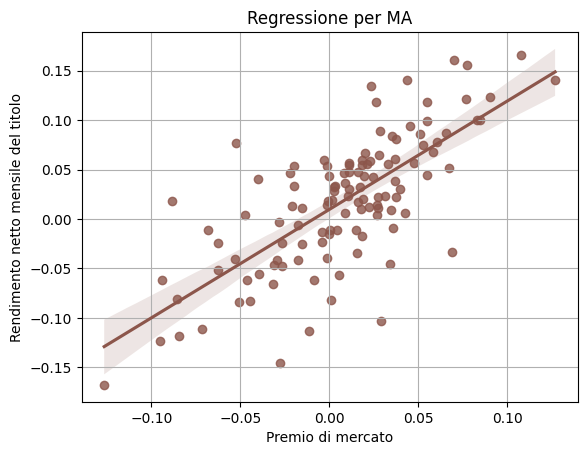

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0096,0.004,2.246,0.027,0.001,0.018
Premio di mercato,1.0964,0.095,11.492,0.000,0.907,1.285


In [229]:
def regressione_OLS(ticker, dati_mensili_titoli, dati_mensili_mercato, colore='blue'):
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_mensili_mercato = dati_mensili_mercato.dropna()
    merged_data = pd.merge(dati_mensili_titoli, dati_mensili_mercato, left_index=True, right_index=True)
    data_ticker = merged_data.loc[ticker]

    X = data_ticker['Premio di mercato']
    Y = data_ticker['Rendimento netto mensile_x'] # rendimento netto mensile del titolo
    X1 = sm.add_constant(X)
    model = sm.OLS(Y, X1)
    results = model.fit()

    plt.figure()
    sns.regplot(x='Premio di mercato', y='Rendimento netto mensile_x', data=data_ticker, color=colore)
    plt.grid(axis='both')
    plt.title(f'Regressione per {ticker}')
    plt.xlabel('Premio di mercato')
    plt.ylabel('Rendimento netto mensile del titolo')
    plt.show()

    html_output = '<h4>Esposizione al rischio di mercato per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    return results.params['const'], results.params['Premio di mercato'], results.tvalues['const']

# Definiamo una lista per accumulare i risultati della regressione
parametri_regressione = []
valori_t = []

for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    intercetta, beta, t_valore = regressione_OLS(ticker, dati_mensili_titoli, sp500, colore)
    parametri_regressione.append([ticker, intercetta, beta])
    valori_t.append(t_valore)

Ricapitoliamo infine in un dataframe il coefficiente beta di ciascun titolo.

In [198]:
# Convertiamo la lista in un DataFrame
coefficienti_capm = pd.DataFrame(parametri_regressione, columns=['Ticker', 'Intercept', 'Beta']).set_index('Ticker')

def significativo(t):
    if abs(t) > 2:
        return 'si'
    else:
        return 'no'

# Aggiungi la colonna 'Significativo' al DataFrame coefficienti_capm
coefficienti_capm['Costante significativa?'] = [significativo(t) for t in valori_t]

coefficienti_capm

,Intercept,Beta,Costante significativa?
Ticker,,,
AAPL,0.011535,1.233159,si
INTC,-0.001812,0.984189,no
AMZN,0.014242,1.276793,si
WMT,0.006868,0.457411,no
V,0.008603,0.962598,si
MA,0.009604,1.096412,si


Dalla stima del modello CAPM emerge che diversi titoli hanno costante significativa (t>2), a testimonianza dell'esistenza di ulteriori fattori di rischio oltre a quello di mercato.

Utilizziamo i valori beta calcolati in precedenza per calcolare il rendimento atteso annuo di ciascun titolo: per stimare il tasso risk-free utilizziamo l'attuale rendimento dei t-bill a un anno, mentre per stimare il rendimento del mercato utilizziamo una proiezione del rendimento dell'indice S&P500 a un anno (per fare ciò prendiamo il rendimento annuo medio avuto dall'indice dal 1980 ad oggi).

I dati dei t-bill provengono dalla banca dati "Federal Reserve Economic Data" (FRED), link: https://fred.stlouisfed.org/series/DGS1

In [199]:
file_path = os.path.join('DatiFinanziari', 'DGS1.csv')
tbill_1anno = pd.read_csv(file_path)
tbill_1anno['DATE'] = pd.to_datetime(tbill_1anno['DATE'])
tbill_1anno.set_index('DATE', inplace=True)
tbill_1anno['DGS1'] = pd.to_numeric(tbill_1anno['DGS1'], errors='coerce')
tbill_1anno['DGS1'] = tbill_1anno['DGS1'] / 100

stima_rf = tbill_1anno['DGS1'].loc[:fine].tail(1).iloc[0]

stima_rf # attuale tasso di interesse sui T-Bill a un anno

0.0518

In [200]:
tbill_1anno = tbill_1anno.resample('YE').last()

tbill_1anno

,DGS1
DATE,
1962-12-31,0.0305
1963-12-31,0.0383
1964-12-31,0.0399
1965-12-31,0.0496
1966-12-31,0.0500
...,...
2020-12-31,0.0010
2021-12-31,0.0039
2022-12-31,0.0473


In [201]:
sp500_storico = prendi_dati_titolo('^GSPC', dt.datetime(1980, 1, 2), fine)
sp500_storico.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
sp500_storico = sp500_storico.resample("YE").last()
sp500_storico['Rendimento netto annuo'] = sp500_storico['Adj Close'].pct_change()
sp500_storico.dropna(inplace=True)

sp500_storico

,Adj Close,Rendimento netto annuo
Date,,
1981-12-31,122.550003,-0.097304
1982-12-31,140.639999,0.147613
1983-12-31,164.929993,0.172710
1984-12-31,167.240005,0.014006
1985-12-31,211.279999,0.263334
1986-12-31,242.169998,0.146204
1987-12-31,247.080002,0.020275
1988-12-31,277.720001,0.124008
1989-12-31,353.399994,0.272505


In [202]:
tbill_1anno = tbill_1anno.loc[sp500_storico.index] # allinea le date di sp500 e t-bill
sp500_storico['Premio di mercato'] = sp500_storico['Rendimento netto annuo'] - tbill_1anno['DGS1']
stima_premio_mercato = sp500_storico['Premio di mercato'].mean()

stima_premio_mercato # media premio di mercato degli ultimi 44 anni

0.05831420353931221

In [203]:
rendimenti_attesi = stima_rf + coefficienti_capm['Beta'] * stima_premio_mercato
rendimenti_attesi = rendimenti_attesi.rename('Rendimento atteso annuo')

rendimenti_attesi

Ticker
AAPL    0.123711
INTC    0.109192
AMZN    0.126255
WMT     0.078474
V       0.107933
MA      0.115736
Name: Rendimento atteso annuo, dtype: float64

Ora calcoliamo l'esposizione dei vari titoli ai fattori di Fama e French. <br>
Sfruttiamo i dati scaricati in precedenza.

In [227]:
from IPython.display import display_html

def regressione_fama_french(ticker, dati_mensili_titoli, dati_fama_french):
    # Step 1: Pulire i dati
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_fama_french = dati_fama_french.dropna()
    dati_fama_french = dati_fama_french.rename(columns={'Mkt-RF': 'MKT'})
    
    # Step 2: Unire i dati basandosi sulle date
    merged_data = dati_mensili_titoli.join(dati_fama_french)
    merged_data.rename(columns={'Premio di rischio': 'premio_rischio'}, inplace=True)

    # Step 3: Filtrare i dati per il ticker specificato
    dati = merged_data.loc[ticker]
    
    results = smf.ols(formula = 'premio_rischio ~ MKT + SMB + HML', data = dati).fit()
    
    html_output = '<h4>Esposizione ai fattori Fama French per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    # Restituire i coefficienti del modello e i valori t
    return results.params, results.tvalues

parametri_fama_french = []
valori_t = []

for ticker in tickers:
    regressione_fama_french(ticker, dati_mensili_titoli, fama_french_mensile)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0074,0.005,1.405,0.163,-0.003,0.018
MKT,1.2330,0.117,10.504,0.000,1.000,1.466
SMB,-0.2218,0.195,-1.135,0.259,-0.609,0.165
HML,-0.5634,0.137,-4.102,0.000,-0.835,-0.291


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0040,0.007,-0.557,0.579,-0.018,0.010
MKT,0.9527,0.159,5.988,0.000,0.638,1.268
SMB,-0.0802,0.265,-0.303,0.763,-0.605,0.445
HML,0.0452,0.186,0.243,0.809,-0.324,0.414


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0088,0.006,1.559,0.122,-0.002,0.020
MKT,1.3138,0.126,10.433,0.000,1.064,1.563
SMB,-0.3186,0.210,-1.520,0.131,-0.734,0.097
HML,-0.9690,0.147,-6.578,0.000,-1.261,-0.677


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0033,0.004,0.752,0.454,-0.005,0.012
MKT,0.5207,0.098,5.293,0.000,0.326,0.716
SMB,-0.5321,0.164,-3.249,0.002,-0.857,-0.208
HML,-0.1899,0.115,-1.650,0.102,-0.418,0.038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0050,0.004,1.328,0.187,-0.002,0.012
MKT,0.9913,0.084,11.802,0.000,0.825,1.158
SMB,-0.4658,0.140,-3.331,0.001,-0.743,-0.189
HML,-0.0942,0.098,-0.959,0.340,-0.289,0.100


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0062,0.004,1.439,0.153,-0.002,0.015
MKT,1.1173,0.096,11.652,0.000,0.927,1.307
SMB,-0.4348,0.160,-2.723,0.007,-0.751,-0.119
HML,0.0349,0.112,0.311,0.756,-0.187,0.257
